# Exercício 6 - SVM
Grupo 14: Gabriel Mendes. Guilherme Araujo

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import pairwise_distances, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, recall_score
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import normalize
from sklearn import preprocessing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def display_all(df):
    with pd.option_context("display.max_rows", 20, "display.max_columns", 300,'display.max_colwidth', -1):
        display(df)

# Leitura e apresentação da base de dados
* 5 características
* 1 variável alvo
* 200 registros

In [ ]:
df = pd.read_csv('../input/drug-classification/drug200.csv')
display_all(df)

# Visualização de valores faltantes
O dataset não tem valores faltantes

In [ ]:
df.info()

# Codificação dos dados
Alguns dados são categóricos.

In [ ]:
categorical_data = ['Sex','BP','Cholesterol']
for column in categorical_data:
    print(column,df[column].unique())

Uma transformação é aplicada para converter todos os dados em numéricos. Os dados da variável alvo são tratados para que não haja ambiguidade na representação.

In [ ]:
df.replace("drugX", "DrugX", inplace = True)
df.replace("drugA", "DrugA", inplace = True)
df.replace("drugA", "DrugA", inplace = True)
df.replace("drugC", "DrugC", inplace = True)
df.replace("drugB", "DrugB", inplace = True)
df = df.replace({'Sex': {'F': 0, 'M': 1}, 'BP': {'HIGH': 1, 'NORMAL': 0, 'LOW': -1}, 'Cholesterol': {'HIGH': 1, 'NORMAL': 0}})
for column in categorical_data:
    print(column,df[column].unique())
df_original=df

# Matriz de correlação
No caso do sexo, uma correlação positiva indica que o sexo masculino apresenta aquela característica com mais frequência. 

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Matriz de Correlação')
sns.heatmap(df.corr(),annot=True,linewidths=3)
plt.show()
plt.savefig('Matriz de Correlação')

# Box plot

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.boxplot(df["Age"])
ax1.set_title("Age")
ax2.boxplot(df["Na_to_K"])
ax2.set_title("Na_to_K")

# Eliminação de outliers
A distância euclideana média foi calculada entre os registros para valiar possíveis outliers.

In [ ]:
escala = MinMaxScaler()
escala.fit(df.iloc[:,:-1])

df_t = escala.transform(df.iloc[:,:-1])

distances = euclidean_distances(df_t,df_t)
m = [np.sum(distances[i])/len(distances[0]) for i in range(len(distances[0]))]
m_ordenado = sorted(m)
plt.scatter(np.arange(0,len(m_ordenado)),m_ordenado)

Valores superiores a 190 foram removidos

In [ ]:
#df_back = df
escala = MinMaxScaler()
escala.fit(df.iloc[m<m_ordenado[190],:-1])

df_t = escala.transform(df.iloc[m<m_ordenado[190],:-1])

distances = euclidean_distances(df_t,df_t)
m2 = [np.sum(distances[i])/len(distances[0]) for i in range(len(distances[0]))]
m_ordenado2 = sorted(m2)
plt.scatter(np.arange(0,len(m_ordenado2)),m_ordenado2)

df = df.iloc[m<m_ordenado[190],:]

df = pd.DataFrame(data=df.to_numpy(),columns=list(df.columns.values))

for k in list(df):
    df[k]=pd.to_numeric(df[k], errors='ignore')
#df=df_back

# Gráfico de projeção
As variáveis não categoóricas apresentam distribuições normais. É possível observar que algumas calsses podem ser facilmente separáveis com essas variáveis.

In [ ]:
ax = sns.set(style="ticks", color_codes='pallete')
ax = sns.pairplot(df.drop(columns=['Sex','Cholesterol','BP']), hue="Drug")

# Normalização
Os dados são colocados na faixa de 0 a 1

In [ ]:
Y=df['Drug']
name=['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
Y_original = df_original['Drug']
X_original = df_original[name]
d = preprocessing.normalize(df[name], axis=0)
df = pd.DataFrame(d, columns=df[name].columns.values)
X=df[name]

#normalMatrix = normalize(X.to_numpy(), norm='l2')
#X = pd.DataFrame(data=normalMatrix,columns=list(X.columns.values))

display_all(df.describe())

# Balanceamento dos dados

In [ ]:
oversample = RandomOverSampler(sampling_strategy='all')
X_oversampled, Y_oversampled = oversample.fit_resample(X, Y)

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x=Y,ax=ax[0]).set_title('Variável alvo')
sns.countplot(x=Y_oversampled,ax=ax[1]).set_title('Oversampling')

X=X_oversampled
Y=Y_oversampled

# Validação cruzada

In [ ]:
def makeTable(headerRow,columnizedData,columnSpacing=2):
    """Creates a technical paper style, left justified table

    Author: Christopher Collett
    Date: 6/1/2019"""
    from numpy import array,max,vectorize

    cols = array(columnizedData,dtype=str)
    colSizes = [max(vectorize(len)(col)) for col in cols]

    header = ''
    rows = ['' for i in cols[0]]

    for i in range(0,len(headerRow)):
        if len(headerRow[i]) > colSizes[i]: colSizes[i]=len(headerRow[i])
        headerRow[i]+=' '*(colSizes[i]-len(headerRow[i]))
        header+=headerRow[i]
        if not i == len(headerRow)-1: header+=' '*columnSpacing

        for j in range(0,len(cols[i])):
            if len(cols[i][j]) < colSizes[i]:
                cols[i][j]+=' '*(colSizes[i]-len(cols[i][j])+columnSpacing)
            rows[j]+=cols[i][j]
            if not i == len(headerRow)-1: rows[j]+=' '*columnSpacing

    line = '-'*len(header)
    print(line)
    print(header)
    print(line)
    for row in rows: print(row)
    print(line)
    
def presentResults(scoresDictionary):
    fitTimeArray = scoresDictionary['fit_time']
    fitTimeMean = mean(fitTimeArray)
    fitTimeStd = std(fitTimeArray)
    
    scoreTimeArray = scoresDictionary['score_time']
    scoreTimeMean = mean(scoreTimeArray)
    scoreTimeStd = std(scoreTimeArray)
    
    precisionArray = scoresDictionary['test_precision_macro']
    precisionMean = mean(precisionArray)
    precisionStd = std(precisionArray)   
    
    recallArray = scoresDictionary['test_recall_macro']
    recallMean = mean(recallArray)
    recallStd = std(recallArray)
        
    f1Array = scoresDictionary['test_f1_macro']
    f1Mean = mean(f1Array)
    f1Std = std(f1Array)
    
    accuracyArray = scoresDictionary['test_accuracy']
    accuracyMean = mean(accuracyArray)
    accuracyStd = std(accuracyArray)
    
    tableHeader = ['Metric', 'Mean', 'Standard Deviation']
    metricRow = ['Precision', 'Accuracy', 'Recall', 'F1-score']
    meanRow = [str(round(precisionMean,2)),str(round(accuracyMean,2)),str(round(recallMean,2)),str(round(f1Mean,2))]
    stdRow = [str(round(precisionStd,2)),str(round(accuracyStd,2)),str(round(recallStd,2)),str(round(f1Std,2))]
    makeTable(tableHeader, [metricRow,meanRow,stdRow])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=5)
X_train_original, X_test_original, Y_train_original, Y_test_original = train_test_split(X_original, Y_original, test_size=0.33, random_state=5)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x=Y_train,ax=ax[0]).set_title('Treino')
sns.countplot(x=Y_test,ax=ax[1]).set_title('Teste')

# Classificador SVM

A Máquina de Vetores de Suporte (*Support Vector Machine* - SVM) calcula a superfície de decisão que melhor separa as classes no conjunto de treinamento. A margem de separação é a menor distância entre os registros do treinamento e a superfície de decisão. A melhor superfície de decisão é aquela que maximiza a margem de separação sem que haja erros no treinamento. Os vetores mais próximos à superfície de decisão são denominados vetores de suporte. 

Para um problema linearmente separável, o hiperplano discriminante é definido pela Equação 1 e assume valores maiores ou iguais que +1 para classes positivas e menores ou iguais que -1 para classes negativas. O hiperplano assume os valores +1 ou -1 para os vetores de suporte e o valor 0 na superfície de separação. O hiperplano ótimo é obtido pela minimização da direção normal ao hiperplano **w**, sujeita às restrições impostas. A Figura 1 ilustra a interpretação geométrica do classificador SVM binário para um problema de duas variáveis. 

\begin{equation}
    f(x)=<\mathbf{w},\mathbf{x}>+b
\end{equation}


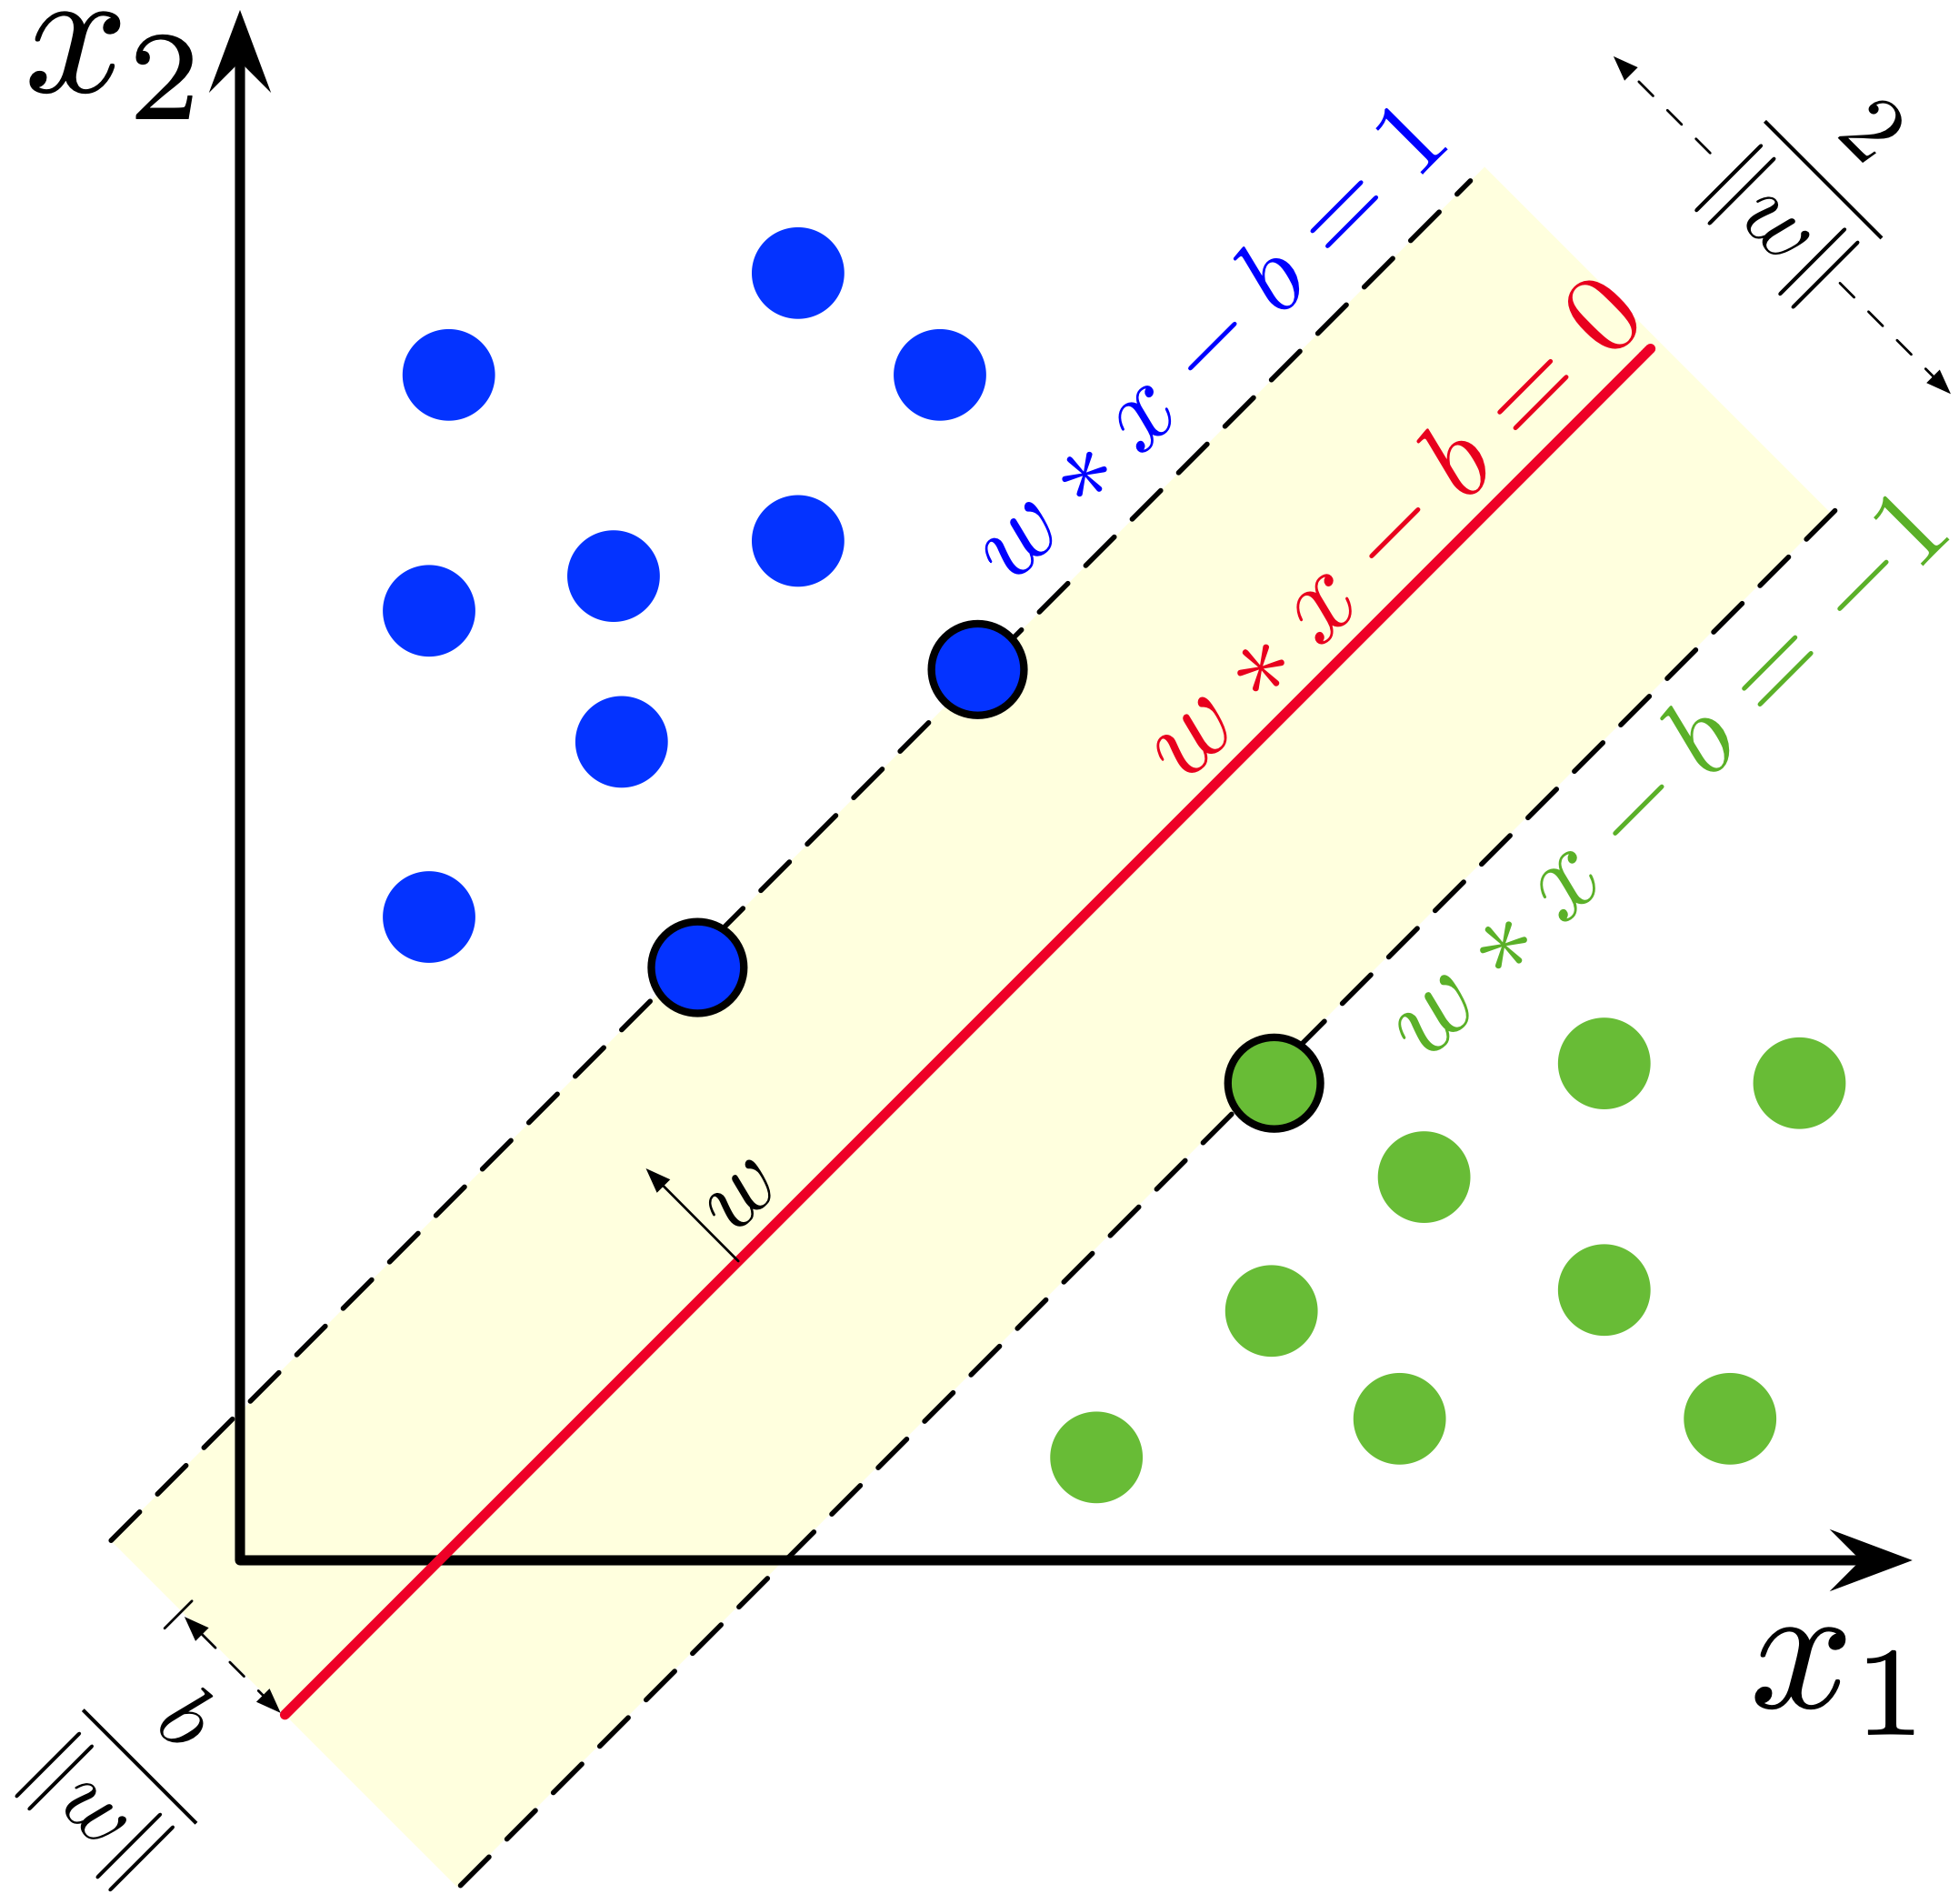

# Classificação com dados originais

In [ ]:
# X_train_original, X_test_original, Y_train_original, Y_test_original

svm = SVC(kernel='rbf')
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']
scores = cross_validate(svm, X_original, Y_original, scoring=scoring, cv=cv, n_jobs=-1)
presentResults(scores)

print("\n\nMatriz de confusão:\n")
svm.fit(X_train_original, Y_train_original)
svm_pred = svm.predict(X_test_original)
matrix = confusion_matrix(Y_test_original, svm_pred)
plot_confusion_matrix(svm, X_test_original, Y_test_original, labels=['DrugY','DrugC','DrugX','DrugA','DrugB'],cmap='Blues')
print(classification_report(Y_test_original, svm_pred, zero_division=1))

# Classificação com dados processados

Utilizamos alguns kernels para experimentação de hiperparâmetros.

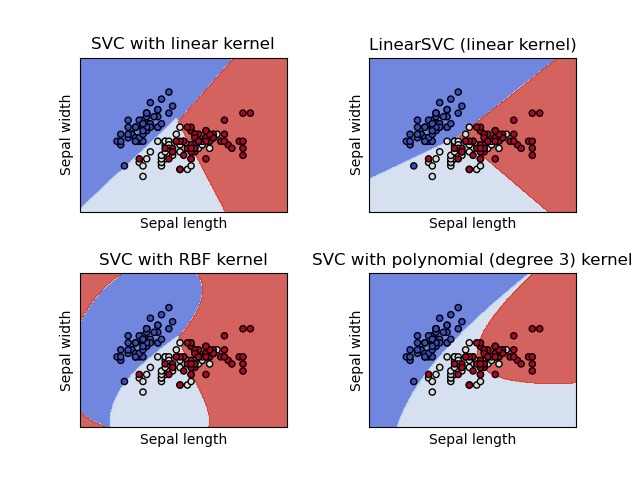

## Kernel Radial Base Function (RBF)

In [ ]:
svm = SVC(kernel='rbf')
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']
scores = cross_validate(svm, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
presentResults(scores)

print("\n\nMatriz de confusão:\n")
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
matrix = confusion_matrix(Y_test, svm_pred)
plot_confusion_matrix(svm, X_test, Y_test, labels=['DrugY','DrugC','DrugX','DrugA','DrugB'],cmap='Blues')
print(classification_report(Y_test, svm_pred, zero_division=1))

## Kernel Polynomial Function

In [ ]:
svm = SVC(kernel='poly', degree=3)
scores = cross_validate(svm, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
presentResults(scores)

print("\n\nMatriz de confusão:\n")
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
matrix = confusion_matrix(Y_test, svm_pred)
plot_confusion_matrix(svm, X_test, Y_test, labels=['DrugY','DrugC','DrugX','DrugA','DrugB'],cmap='Blues')
print(classification_report(Y_test, svm_pred, zero_division=1))

## Kernel Linear

In [ ]:
svm = SVC(kernel='linear')
scores = cross_validate(svm, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
presentResults(scores)

print("\n\nMatriz de confusão:\n")
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
matrix = confusion_matrix(Y_test, svm_pred)
plot_confusion_matrix(svm, X_test, Y_test, labels=['DrugY','DrugC','DrugX','DrugA','DrugB'],cmap='Blues')
print(classification_report(Y_test, svm_pred, zero_division=1))

## Kernel Sigmoid

In [ ]:
svm = SVC(kernel='sigmoid')
scores = cross_validate(svm, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
presentResults(scores)

print("\n\nMatriz de confusão:\n")
svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
matrix = confusion_matrix(Y_test, svm_pred)
plot_confusion_matrix(svm, X_test, Y_test, labels=['DrugY','DrugC','DrugX','DrugA','DrugB'],cmap='Blues')
print(classification_report(Y_test, svm_pred, zero_division=1))

## Grau do polinômio

In [ ]:
currentMaximum=0
bestDegree=0

for degree in range(1,11):
    svm = SVC(kernel='poly',degree=degree, C=1)
    scores = cross_validate(svm, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
    #print(scores)
    f1Array = scores['test_f1_macro']
    f1Mean = mean(f1Array)
    f1Std = std(f1Array)
    accuracyArray = scores['test_accuracy']
    accuracyMean = mean(accuracyArray)
    accuracyStd = std(accuracyArray)
    if (accuracyMean > currentMaximum):
        currentMaximum = accuracyMean
        bestDegree = degree
    print("Degree: ", degree, 
          #" | F1-Score: ", str(round(f1Mean,4)), " +- ", str(round(f1Std,4)),
          " | Accuracy: ", str(round(accuracyMean,4)), " +- ", str(round(accuracyStd,4)))
print("\nBest degree: ", str(bestDegree))

## Parâmetro de regularização

In [ ]:
currentMaximum=0
bestC=0

print("Polynomial degree: 8\n")
degree=8

for c in range(1,20,1):
    svm = SVC(kernel='poly',degree=degree,C=c/10)
    scores = cross_validate(svm, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
    #print(scores)
    f1Array = scores['test_f1_macro']
    f1Mean = mean(f1Array)
    f1Std = std(f1Array)
    accuracyArray = scores['test_accuracy']
    accuracyMean = mean(accuracyArray)
    accuracyStd = std(accuracyArray)
    if (accuracyMean > currentMaximum):
        currentMaximum = accuracyMean
        bestC = c/10
    print("c: ", c/10, 
          #" | F1-Score: ", str(round(f1Mean,4)), " +- ", str(round(f1Std,4)),
          " | Accuracy: ", str(round(accuracyMean,4)), " +- ", str(round(accuracyStd,4)))
print("\nBest C: ", str(bestC),"\n")

# Conclusão

Utilizando o conjunto de dados original os resultados foram ruins, portantos optamos por um pré processamento dos dados, sendo a normalização das variáveis de idade e Na_to_K a ação de maior impacto.

Com isso realizamos testes em quatro diferentes kernels do SVM, e é notável a diferença de performance entre o RBf e polinomial em relação às demais, sendo este último o maior destaque. De forma geral, independente do grau utilizado o desempenho foi bom, sendo o melhor a partir do grau três, sem diferenças notáveis.

